# BM3 GNN Pred

In [1]:
from typing import *
import numpy as np
from functools import partial

import torch
from torch import Tensor, nn
import torch.nn.functional as F

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

In [2]:
DEVICE = torch.device("cpu")

In [3]:
from tomopt.volume.layer import Layer

def get_volume(size: float = 0.2, lwh: Tensor = Tensor([1.0, 1.0, 1.4]), device: torch.device = torch.device("cpu")) -> Volume:
    def area_cost(x: Tensor) -> Tensor:
        return F.relu(x)

    layers: List[Layer] = []
    n_panels = 4
    layers.append(
        PanelDetectorLayer(
            pos="above",
            lw=lwh[:2],
            z=lwh[2].item(),
            size=size,
            panels=[
                DetectorPanel(
                    res=1e3, eff=1, init_xyz=(lwh[0].item()/2, lwh[1].item()/2, lwh[2].item() - (i * (size) / n_panels)), init_xy_span=(lwh[0].item(), lwh[1].item()), area_cost_func=area_cost, device=device
                )
                for i in range(n_panels)
            ],
        )
    )
    for z in np.round(np.arange(lwh[2] - size, size, -size), decimals=1):
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=device))
    layers.append(
        PanelDetectorLayer(
            pos="below",
            lw=lwh[:2],
            z=size,
            size=size,
            panels=[
                DetectorPanel(
                    res=1e3, eff=1, init_xyz=(lwh[0].item()/2, lwh[1].item()/2, size - (i * (size) / n_panels)), init_xy_span=(lwh[0].item(), lwh[1].item()), area_cost_func=area_cost, device=device
                )
                for i in range(n_panels)
            ],
        )
    )

    return Volume(nn.ModuleList(layers))

In [4]:
volume = get_volume(device=DEVICE)

In [5]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4000]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.3500]), and xy span tensor([1., 1.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.3000]), and xy span tensor([1., 1.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.2500]), and xy span tensor([1., 1.])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.2000]), and xy span tensor(

In [6]:
muons = MuonBatch(generate_batch(250), init_z=volume.h, device=DEVICE)

In [7]:
gen = RandomBlockPassiveGenerator(
        block_size=None, volume=volume, sort_x0=False, enforce_diff_mat=True, materials=["beryllium", "carbon", "silicon", "iron", "lead"], block_size_max_half=False
    )

In [8]:
volume.load_rad_length(*gen.get_data())

In [9]:
volume(muons)

In [10]:
volume.target

tensor([0.1932])

In [11]:
sb = ScatterBatch(muons, volume)

In [12]:
sb.location

tensor([[ 4.0514e-03,  6.5792e-01,  6.4280e-01],
        [ 4.1013e-01,  7.7891e-01,  1.6821e+00],
        [-1.5440e-01,  6.2376e-01,  2.8436e-01],
        [ 6.3282e-01,  2.0160e-01,  1.0351e+00],
        [ 1.0833e+00,  6.1057e-01,  2.6184e-01],
        [ 3.7461e-01,  7.6878e-01,  5.0194e-01],
        [ 8.6035e-01,  4.5179e-01, -1.3317e-02],
        [ 9.4571e-01,  8.2125e-01,  1.2100e+00],
        [ 7.6564e-01, -2.8392e-01, -3.9767e-01],
        [ 8.1560e-01,  9.0087e-01,  7.8056e-01],
        [ 7.2012e-01,  3.5422e-01,  5.7469e-01],
        [ 2.4906e-01,  1.0334e-01,  1.6681e-01],
        [ 4.3821e-01,  8.5484e-01,  6.7859e-01],
        [ 4.8259e-01,  3.4637e-01,  7.0547e-01],
        [ 8.5106e-01,  2.6406e-02,  1.2356e+00],
        [ 5.3760e-01,  3.9553e-01,  9.0061e-01],
        [ 8.9188e-01,  5.5856e-01,  1.2369e+00],
        [ 6.1432e-01,  8.2141e-01,  6.2674e-01],
        [ 3.1369e-01,  2.8158e-01,  8.7994e-01],
        [ 8.8623e-01,  9.4763e-01,  6.7068e-01],
        [ 4.1417e-01

## GNN inferer

In [13]:
model = torch.jit.load('../../mode_muon_tomo_inference/dev/exported_models/bm3_traced.pt')

In [14]:
type(model)

torch.jit._script.RecursiveScriptModule

In [15]:
dvi = DeepVolumeInferer(model=model, base_inferer=PanelX0Inferer(volume), volume=volume)

In [16]:
dvi.in_vars, dvi.in_var_uncs

([], [])

In [17]:
dvi.add_scatters(sb)

/Users/giles/cernbox/mode_muon_tomography/tomopt/inference/scattering.py:247: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  idxs = torch.combinations(torch.arange(0, unc.shape[-1]), with_replacement=True)


In [18]:
dvi.in_vars[0].shape, dvi.in_var_uncs[0].shape

(torch.Size([250, 8]), torch.Size([250, 8]))

In [19]:
%%time
p,w = dvi.get_prediction()

CPU times: user 3.74 s, sys: 334 ms, total: 4.07 s
Wall time: 1.54 s


In [20]:
torch.exp(p).shape

torch.Size([1, 5, 125])

In [21]:
p

tensor([[[-4.8087, -3.6494, -3.2129, -3.5707, -4.7962, -3.6117, -2.6616,
          -2.3701, -2.6066, -3.5137, -3.2035, -2.3817, -2.1460, -2.3469,
          -3.1517, -3.4951, -2.5999, -2.3446, -2.5724, -3.5319, -4.5737,
          -3.5047, -3.1636, -3.5337, -4.8512, -3.2776, -2.2781, -2.0057,
          -2.1901, -3.0297, -2.2990, -1.7073, -1.5651, -1.6379, -2.1529,
          -2.0545, -1.6045, -1.4973, -1.5440, -1.9378, -2.1946, -1.6800,
          -1.5666, -1.6401, -2.1469, -2.9644, -2.1300, -1.9352, -2.1277,
          -2.9945, -2.7044, -1.8306, -1.5844, -1.7198, -2.4249, -1.8727,
          -1.4211, -1.3196, -1.3296, -1.6532, -1.6626, -1.3577, -1.2930,
          -1.2935, -1.4909, -1.7715, -1.3912, -1.3168, -1.3361, -1.6367,
          -2.3719, -1.7079, -1.5391, -1.6605, -2.3204, -3.0967, -2.0231,
          -1.6991, -1.8647, -2.7668, -2.0683, -1.4276, -1.2787, -1.3212,
          -1.8079, -1.7703, -1.3164, -1.2214, -1.2271, -1.5786, -1.9239,
          -1.3706, -1.2467, -1.2792, -1.7423, -2.74

In [22]:
%%time
# jacobian(p, dvi.in_var)  # crashes

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


## Loss

In [23]:
x02id = {X0[m]: i for i, m in enumerate(gen.materials)}; x02id

{0.3528: 0, 0.1932: 1, 0.0937: 2, 0.01757: 3, 0.005612: 4}

In [24]:
loss = VoxelClassLoss(x02id=x02id, target_budget=None)

In [25]:
l = loss(p, 1, volume); l

Automatically setting cost coefficient to 2.378434181213379


tensor([2.3784], grad_fn=<AddBackward0>)

In [26]:
jacobian(l, volume.get_detectors()[0].panels[0].xy)

tensor([[-0.0067, -0.5824]])

In [27]:
jacobian(l, volume.get_detectors()[0].panels[0].xy_span)

tensor([[ 0.0097, -0.1994]])

In [28]:
jacobian(l, volume.get_detectors()[0].panels[0].z)

tensor([[-30.1736]])

## Plotting

In [29]:
class_preds = p.argmax(1).detach().cpu().numpy()

In [30]:
true = volume.get_rad_cube().flatten().reshape((5,5,5))

In [31]:
class_preds = class_preds.reshape(true.shape)

In [32]:
id2x0 = {v:k for k,v in x02id.items()}; id2x0

{0: 0.3528, 1: 0.1932, 2: 0.0937, 3: 0.01757, 4: 0.005612}

In [33]:
x0_preds = class_to_x0preds(class_preds, id2x0)

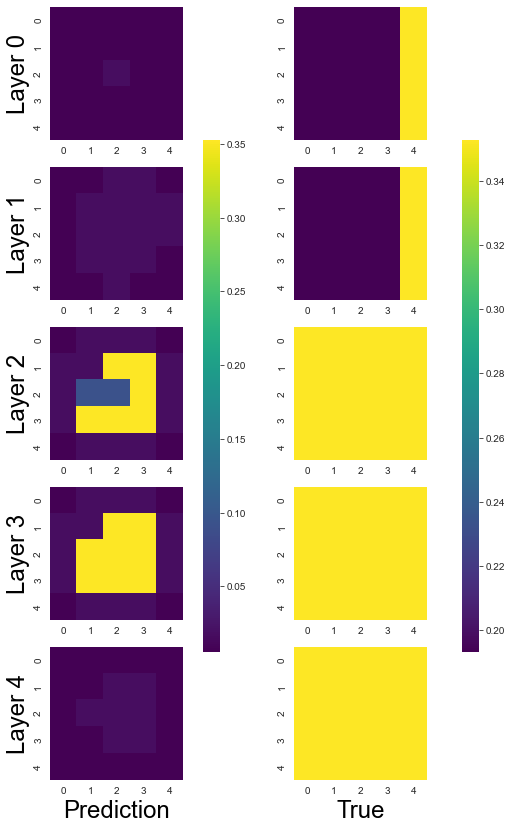

In [34]:
plot_pred_true_x0(x0_preds, true)

In [35]:
x02id

{0.3528: 0, 0.1932: 1, 0.0937: 2, 0.01757: 3, 0.005612: 4}

In [36]:
class_targs = x0targs_to_classtargs(true, x02id)

In [37]:
class_targs

array([[[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.]],

       [[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]], dtype=float32)

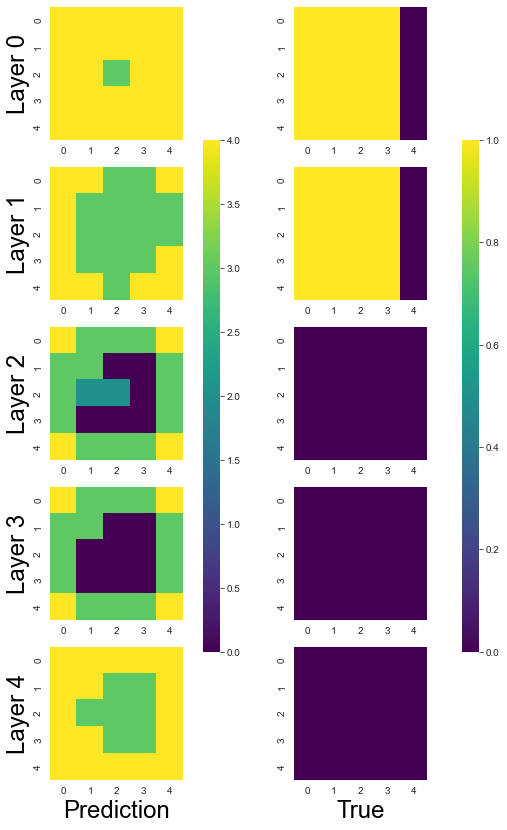

In [38]:
plot_pred_true_x0(class_preds, class_targs)

## Optimiser

In [39]:
volume.get_cost()

tensor(8., grad_fn=<AddBackward0>)

In [40]:
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xy_span_opt=partial(torch.optim.SGD, lr=1e4),
                             partial_volume_inferer=partial(DeepVolumeInferer, model=model, base_inferer=PanelX0Inferer(volume)),
                             loss_func=VoxelClassLoss(x02id=x02id, target_budget=6, cost_coef=None))  # Loss is precision + budget_coef*cost_coef, balance coef as required or leave as None to automatically balance on first batch

In [41]:
passives = PassiveYielder(gen, n_passives=1)

In [43]:
from prettytable import PrettyTable

from tomopt.optimisation.callbacks.callback import Callback

class PanelOptConfig(Callback):
    def __init__(self, n_warmup:int, xy_pos_rate:float, z_pos_rate:float, xy_span_rate:float):
        self.n_warmup = n_warmup
        self.rates = {'xy_pos_opt':xy_pos_rate, 'z_pos_opt':z_pos_rate,'xy_span_opt':xy_span_rate}
    
    def on_train_begin(self) -> None:
        super().on_train_begin()
        self.epoch_cnt = 0
        self.tracking = True
        self.stats = {'xy_pos_opt':[], 'z_pos_opt':[],'xy_span_opt':[]}
        print(f"{type(self).__name__}: Freezing optimisation for {self.n_warmup} epochs")
        for o in self.stats:  # Prevent updates during warmup
            self.wrapper.set_opt_lr(0.0, o)
            
    def on_backwards_end(self) -> None:
        for l in self.wrapper.volume.get_detectors():
            if isinstance(l, PanelDetectorLayer):
                for p in l.panels:
                    self.stats['xy_pos_opt'].append(p.xy.grad.cpu().numpy())
                    self.stats['z_pos_opt'].append(p.z.grad.cpu().numpy())
                    self.stats['xy_span_opt'].append(p.xy_span.grad.cpu().numpy())

    def on_epoch_end(self) -> None:
        if self.tracking and self.wrapper.fit_params.state == "train":
            self.epoch_cnt += 1
            if self.epoch_cnt == self.n_warmup:
                print(f"{type(self).__name__}: Optimiser warm-up completed")
                self.tracking = False
                pt = PrettyTable(['Param', 'Median Grad', 'LR'])
                for k,v in self.stats.items():  # Allow optimisation
                    avg = np.abs(np.median(v))
                    lr = self.rates[k]/avg
                    pt.add_row([k, avg, lr])
                    self.wrapper.set_opt_lr(lr, k)
                print(pt)

CostCoefWarmup: Freezing optimisation for 5 epochs
PanelOptConfig: Freezing optimisation for 5 epochs


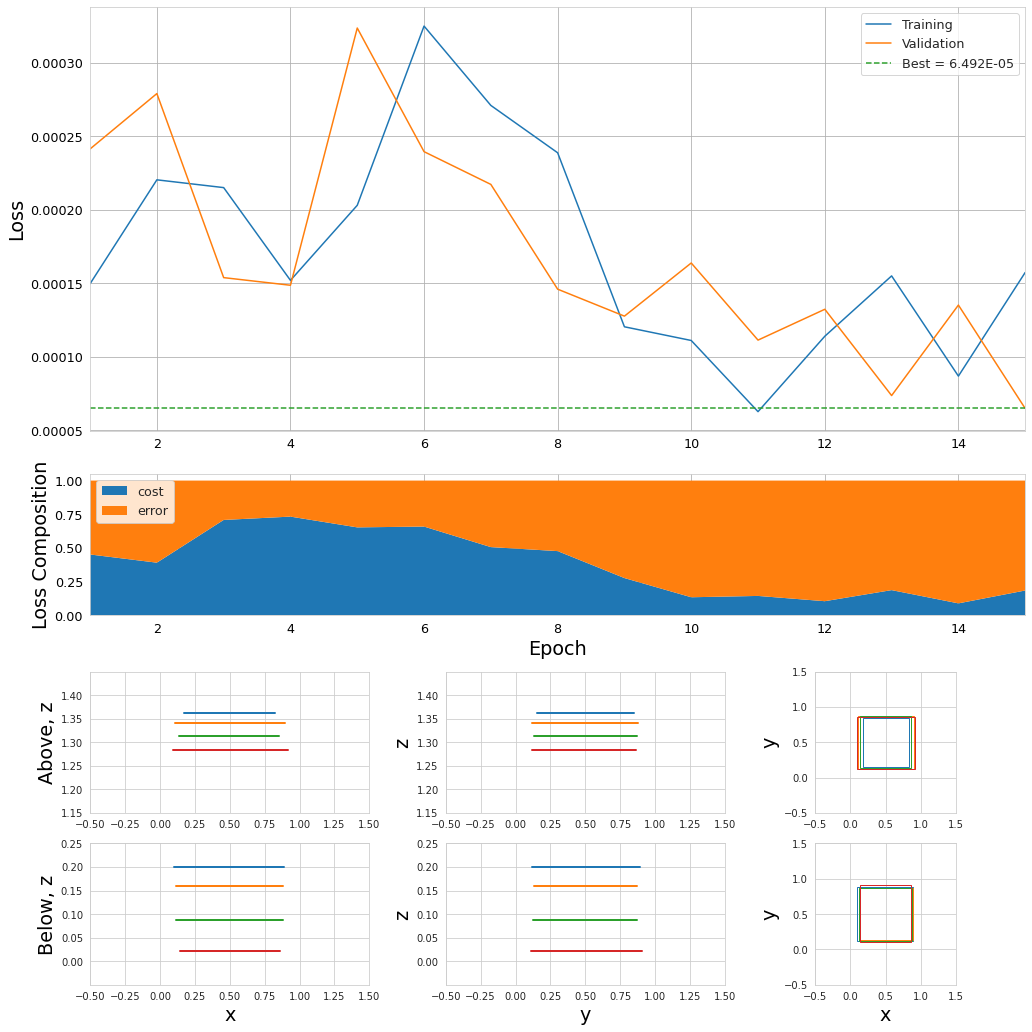

Automatically setting cost coefficient to 4.0827435441315174e-05


/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:211: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


CostCoefWarmup: Warmed up, average error = tensor([7.9147e-05])
PanelOptConfig: Optimiser warm-up completed
+-------------+----------------+--------------------+
|    Param    |  Median Grad   |         LR         |
+-------------+----------------+--------------------+
|  xy_pos_opt |  0.001060002   | 94.33944306137448  |
|  z_pos_opt  |   0.06313047   | 0.7920106009185638 |
| xy_span_opt | 0.000114580616 | 872.7479671624808  |
+-------------+----------------+--------------------+


<Figure size 1024x1024 with 0 Axes>

In [44]:
_ = wrapper.fit(n_epochs=15,
                passive_bs=1,
                n_mu_per_volume=250,
                mu_bs=250,
                trn_passives=passives,
                val_passives=passives,
                cbs=[NoMoreNaNs(), CostCoefWarmup(n_warmup=5), PanelOptConfig(n_warmup=5, xy_pos_rate=0.1, z_pos_rate=0.05, xy_span_rate=0.1), PanelMetricLogger()])

In [45]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5006, 0.5003]), z=tensor([1.3628]), and xy span tensor([0.6503, 0.6974])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5027, 0.4981]), z=tensor([1.3409]), and xy span tensor([0.7884, 0.7530])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.4959, 0.4988]), z=tensor([1.3128]), and xy span tensor([0.7174, 0.7356])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5061, 0.4898]), z=tensor([1.2831]), and xy span tensor([0.8249, 0.7394])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.4936, 0.5046]), z=tenso

In [46]:
volume.get_cost()

tensor(4.4952, grad_fn=<AddBackward0>)

In [47]:
muons = MuonBatch(generate_batch(250), init_z=volume.h, device=DEVICE)

In [48]:
volume(muons)

In [49]:
volume.target

tensor([0.0176])

In [50]:
sb = ScatterBatch(muons, volume)

In [51]:
sb.location[:5]

tensor([[0.8321, 0.6844, 0.8176],
        [0.3103, 0.9342, 1.3062],
        [0.0862, 0.5581, 1.0160],
        [0.5284, 0.7939, 0.7873],
        [0.9366, 0.8227, 1.5029]], grad_fn=<SliceBackward0>)

In [52]:
sb.above_hits[:5]

tensor([[[0.8341, 0.6924, 1.3628],
         [0.8338, 0.6929, 1.3409],
         [0.8353, 0.6918, 1.3128],
         [0.8330, 0.6921, 1.2831]],

        [[0.3122, 0.9299, 1.3628],
         [0.3117, 0.9311, 1.3409],
         [0.3107, 0.9346, 1.3128],
         [0.3091, 0.9383, 1.2831]],

        [[0.0773, 0.5625, 1.3628],
         [0.0776, 0.5610, 1.3409],
         [0.0785, 0.5603, 1.3128],
         [0.0806, 0.5599, 1.2831]],

        [[0.4602, 0.7163, 1.3628],
         [0.4648, 0.7189, 1.3409],
         [0.4685, 0.7241, 1.3128],
         [0.4711, 0.7279, 1.2831]],

        [[0.9432, 0.8310, 1.3628],
         [0.9450, 0.8344, 1.3409],
         [0.9464, 0.8346, 1.3128],
         [0.9495, 0.8348, 1.2831]]], grad_fn=<SliceBackward0>)

In [53]:
sb.above_hit_uncs[:5]

tensor([[[0.0013, 0.0011, 0.0000],
         [0.0012, 0.0011, 0.0000],
         [0.0012, 0.0011, 0.0000],
         [0.0012, 0.0011, 0.0000]],

        [[0.0011, 0.0015, 0.0000],
         [0.0011, 0.0014, 0.0000],
         [0.0011, 0.0014, 0.0000],
         [0.0011, 0.0014, 0.0000]],

        [[0.0015, 0.0010, 0.0000],
         [0.0013, 0.0010, 0.0000],
         [0.0014, 0.0010, 0.0000],
         [0.0013, 0.0010, 0.0000]],

        [[0.0010, 0.0011, 0.0000],
         [0.0010, 0.0011, 0.0000],
         [0.0010, 0.0011, 0.0000],
         [0.0010, 0.0011, 0.0000]],

        [[0.0016, 0.0013, 0.0000],
         [0.0014, 0.0012, 0.0000],
         [0.0015, 0.0012, 0.0000],
         [0.0013, 0.0012, 0.0000]]], grad_fn=<SliceBackward0>)

In [54]:
sb.above_hit_uncs[:5]

tensor([[[0.0013, 0.0011, 0.0000],
         [0.0012, 0.0011, 0.0000],
         [0.0012, 0.0011, 0.0000],
         [0.0012, 0.0011, 0.0000]],

        [[0.0011, 0.0015, 0.0000],
         [0.0011, 0.0014, 0.0000],
         [0.0011, 0.0014, 0.0000],
         [0.0011, 0.0014, 0.0000]],

        [[0.0015, 0.0010, 0.0000],
         [0.0013, 0.0010, 0.0000],
         [0.0014, 0.0010, 0.0000],
         [0.0013, 0.0010, 0.0000]],

        [[0.0010, 0.0011, 0.0000],
         [0.0010, 0.0011, 0.0000],
         [0.0010, 0.0011, 0.0000],
         [0.0010, 0.0011, 0.0000]],

        [[0.0016, 0.0013, 0.0000],
         [0.0014, 0.0012, 0.0000],
         [0.0015, 0.0012, 0.0000],
         [0.0013, 0.0012, 0.0000]]], grad_fn=<SliceBackward0>)

In [55]:
sb.above_gen_hits[:5]

tensor([[[0.8339, 0.6927, 1.3628],
         [0.8339, 0.6923, 1.3409],
         [0.8339, 0.6917, 1.3128],
         [0.8339, 0.6912, 1.2831]],

        [[0.3135, 0.9292, 1.3628],
         [0.3122, 0.9310, 1.3409],
         [0.3106, 0.9333, 1.3128],
         [0.3089, 0.9357, 1.2831]],

        [[0.0785, 0.5636, 1.3628],
         [0.0787, 0.5626, 1.3409],
         [0.0789, 0.5612, 1.3128],
         [0.0792, 0.5598, 1.2831]],

        [[0.4618, 0.7166, 1.3628],
         [0.4646, 0.7194, 1.3409],
         [0.4682, 0.7229, 1.3128],
         [0.4720, 0.7266, 1.2831]],

        [[0.9432, 0.8317, 1.3628],
         [0.9452, 0.8328, 1.3409],
         [0.9476, 0.8341, 1.3128],
         [0.9503, 0.8356, 1.2831]]], grad_fn=<SliceBackward0>)